In [1]:
from sklearn import datasets
import warnings
import optuna
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
import shap
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from pymoo.factory import get_performance_indicator
from optuna.exceptions import TrialPruned
from autocluster.autohypothesis import autohypothesis_utils

In [2]:
star_df = pd.read_csv('star_classification.csv')
star_df.rename(columns={"class": "target"}, inplace=True)
star_df.drop(columns=['obj_ID',"fiber_ID","run_ID","rerun_ID","field_ID","spec_obj_ID","fiber_ID"], inplace=True)#,"redshift"
_, star_df = train_test_split(star_df, test_size=0.05, stratify=star_df['target'], random_state=42)


In [3]:
import pandas as pd
import numpy as np

# Initialisation de la liste pour stocker les résultats
results = []

# Nombre de runs
n_runs = 1  # Définissez n selon votre besoin

for run in range(n_runs):
    print(run + 1)
    # Exécutez le code original
    exp, X_train, X_dev, y_train, y_dev = autohypothesis_utils.opti_loop(star_df, 500, optimize_obj="solo")
    all_objectives = np.array([trial.values for trial in exp.best_trials])
    sorted_objectives = all_objectives[np.argsort(all_objectives[:, 0])]
    params = autohypothesis_utils.get_trial_hyperparams(exp, trial_number=exp.best_trials[0].number)
    pipeline = autohypothesis_utils.rebuild_pipeline_with_hyperparams(params)
    pipeline.fit(X_train, y_train)
    acc = accuracy_score(y_dev, pipeline.predict(X_dev))
    entropy = autohypothesis_utils.clusterEntropy(pipeline, X_dev, pipeline.predict(X_dev))
    
    # Stockage des résultats pour cette itération
    results.append({
        "run_number": run + 1,
        "accuracy": acc,
        "entropy": 1 - entropy,
        "params": exp.best_trials[0].params
    })

# Création du DataFrame pour toutes les runs
df_runs = pd.DataFrame(results)

# Calcul de la moyenne des accuracies et entropies
avg_accuracy = np.mean(df_runs["accuracy"])
avg_entropy = np.mean(df_runs["entropy"])

# Création du DataFrame pour les moyennes
df_avg = pd.DataFrame([{
    "avg_accuracy": avg_accuracy,
    "avg_entropy": avg_entropy
}])

print(df_runs)
print(df_avg)


[I 2024-04-25 13:54:18,346] A new study created in memory with name: no-name-b307b9ac-2c78-4751-aea0-659ebaa33b50


1


[I 2024-04-25 13:54:18,918] Trial 0 finished with value: 0.5946666666666667 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 560, 'rf_max_depth': 16, 'rf_min_samples_split': 0.8408045247373404, 'rf_min_samples_leaf': 0.17699985473719596, 'rf_max_features': 'log2', 'rf_random_state': 42}. Best is trial 0 with value: 0.5946666666666667.
[I 2024-04-25 13:54:19,451] Trial 1 finished with value: 0.5946666666666667 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 530, 'rf_max_depth': 13, 'rf_min_samples_split': 0.21215541819728584, 'rf_min_samples_leaf': 0.45125272521928494, 'rf_max_features': 'sqrt', 'rf_random_state': 42}. Best is trial 0 with value: 0.5946666666666667.
[I 2024-04-25 13:54:19,760] Trial 2 finished with value: 0.8013333333333333 and parameters: {'classifier': 'RandomForest', 'rf_n_estimators': 190, 'rf_max_depth': 26, 'rf_min_samples_split': 0.4815838012758249, 'rf_min_samples_leaf': 0.0838896466921889, 'rf_max_features': 'sqrt', 'rf_random

   run_number  accuracy   entropy  \
0           1  0.958667  0.634476   

                                              params  
0  {'classifier': 'RandomForest', 'rf_n_estimator...  
   avg_accuracy  avg_entropy
0      0.958667     0.634476


In [4]:
df_runs

,run_number,accuracy,entropy,params
0,1,0.958667,0.634476,"{'classifier': 'RandomForest', 'rf_n_estimator..."


In [5]:
df_runs.to_csv("runs_solo_stellar_500.csv")
df_avg.to_csv("avg_solo_stellar_500.csv")

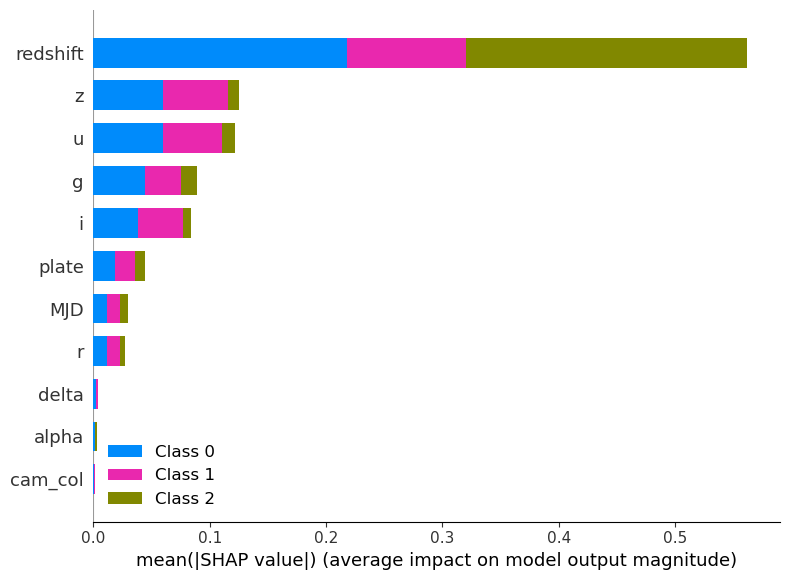

In [6]:
import shap

# Initialize your explainer
explainer = shap.TreeExplainer(pipeline.named_steps['classifier'])
explain_shap = explainer(X_dev)
# Compute SHAP values
shap_values = explainer.shap_values(X_dev)

# Summarize the SHAP values in a plot
shap.summary_plot(shap_values, X_dev)


In [7]:
import numpy as np

unique_classes = np.unique(y_dev)
random_ids = {}

for cls in unique_classes:
    # Obtenir les indices de toutes les instances de cette classe
    class_indices = np.where(y_dev == cls)[0]
    # Sélectionner aléatoirement un indice parmi ces indices
    random_id = np.random.choice(class_indices)
    random_ids[cls] = random_id

print(random_ids)


{0: 1088, 1: 1441, 2: 685}


In [8]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][random_ids[0]], X_dev.iloc[random_ids[0]])


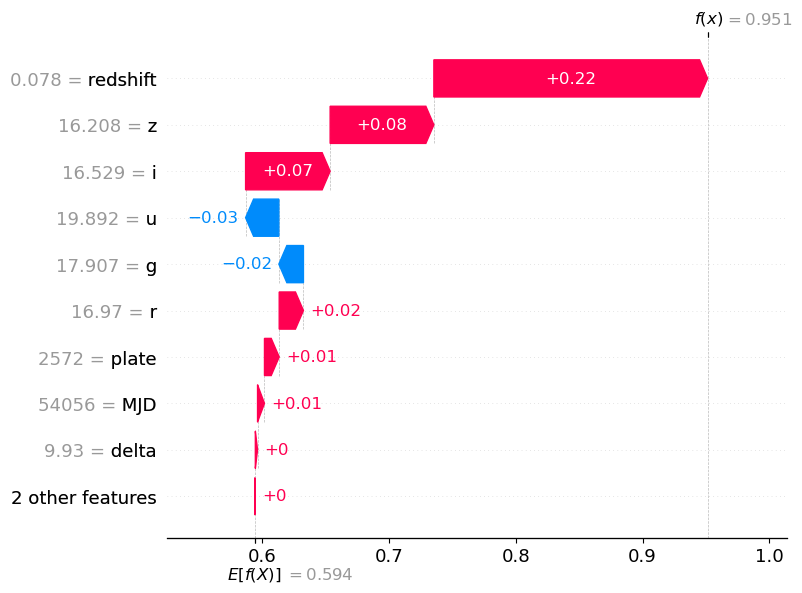

In [9]:
row = random_ids[0]
shap.waterfall_plot(shap.Explanation(values=shap_values[0][row], 
                                              base_values=explainer.expected_value[0], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [10]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][random_ids[1]], X_dev.iloc[random_ids[1]])

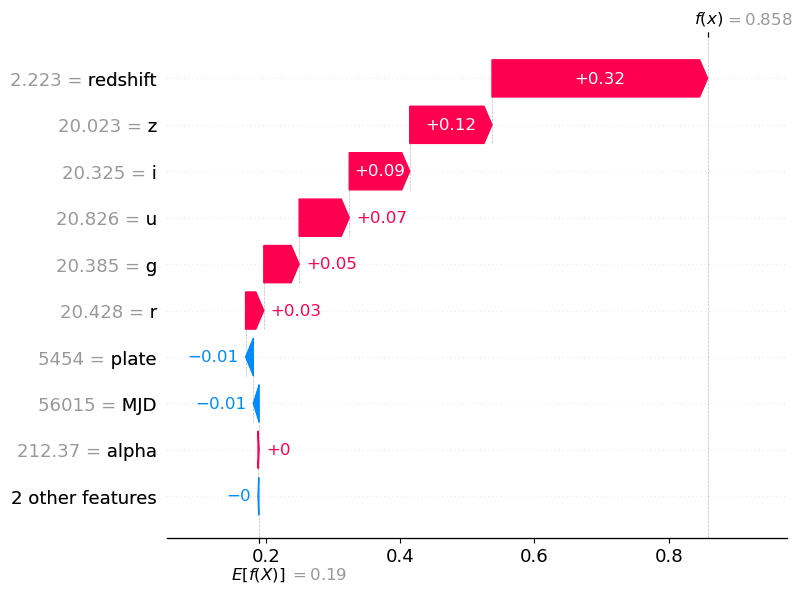

In [11]:
row = random_ids[1]
shap.waterfall_plot(shap.Explanation(values=shap_values[1][row], 
                                              base_values=explainer.expected_value[1], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))

In [12]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][random_ids[2]], X_dev.iloc[random_ids[2]])

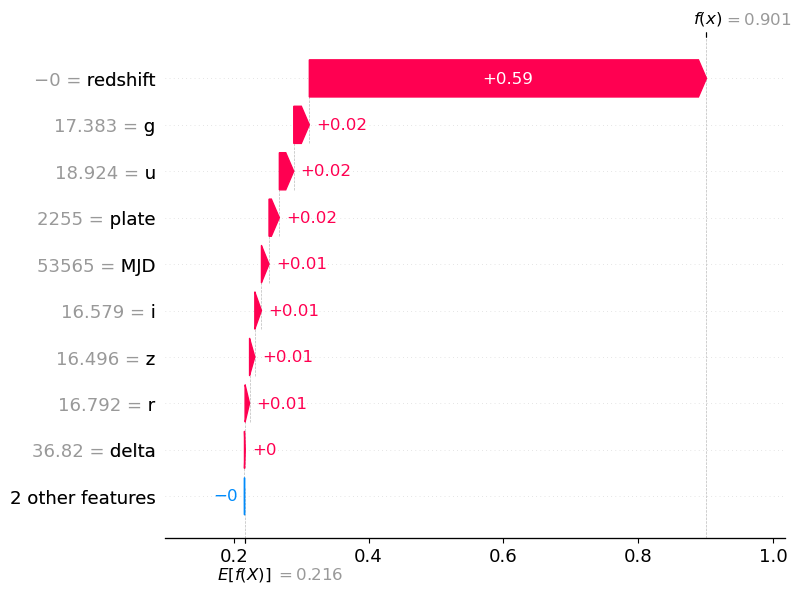

In [13]:
row = random_ids[2]
shap.waterfall_plot(shap.Explanation(values=shap_values[2][row], 
                                              base_values=explainer.expected_value[2], data=X_dev.iloc[row],  
                                         feature_names=X_dev.columns.tolist()))